<a href="https://colab.research.google.com/github/WilfriKusnadi/superduperimageanalysis/blob/main/analyze_drops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python numpy matplotlib scipy


STAGE 1: Drop Detection & Labeling
Upload your drop image:


Saving temp-3.PNG to temp-3 (11).PNG
Processing: temp-3 (11).PNG
Image dimensions: 7026 x 4755
Total contours detected using grayscale threshold: 444
FILTERING STATISTICS:
Total contours found: 444
Filtered out - too small (area < 3): 16
Filtered out - no perimeter: 0
Filtered out - too close to edges: 3
Passed initial filters: 425
After scoring: 425 candidates

Implementing step-by-step ranking algorithm...
Step 1: Edge filtering - already applied during initial scoring
Step 2: Proximity filtering...
PROXIMITY FILTERING ALGORITHM:
Input: 425 candidates
Minimum centerpoint distance: 20 pixels
Algorithm:
1. Sort candidates by score (highest first)
2. For each candidate:
   - Check distance to all already-accepted drops
   - If distance < 20 pixels to ANY accepted drop: REJECT
   - Else: ACCEPT and add to final list
3. This keeps highest-scoring drop when multiple drops are close
   Rejected #1: drop at (509.5,4370.0) score=59.6
             too close (12.6px) to drop at (514.4,4381.6)
 

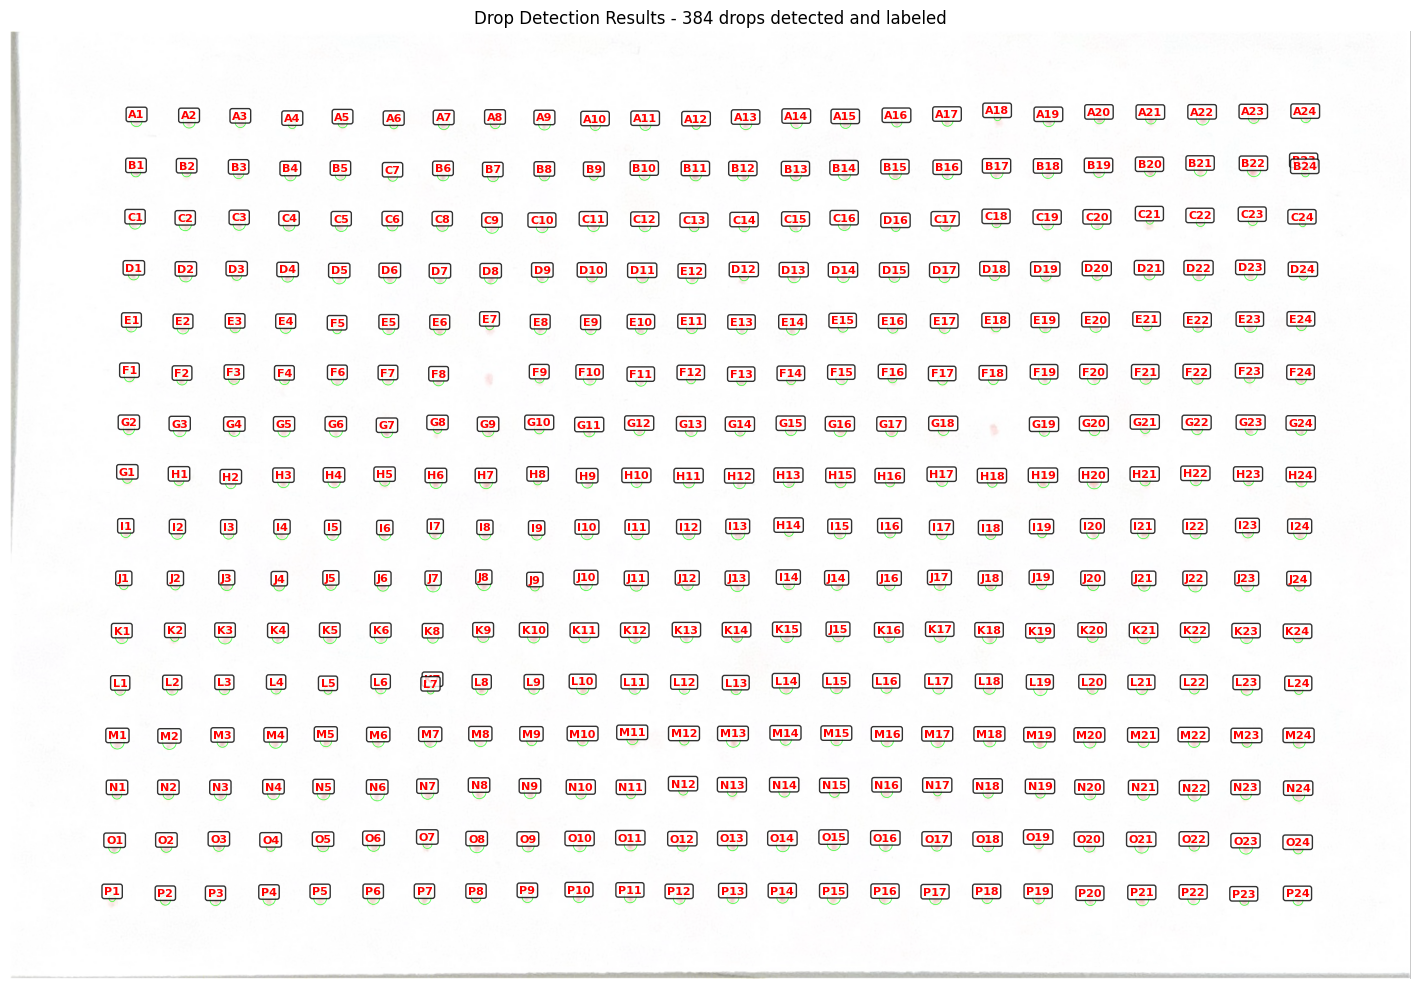

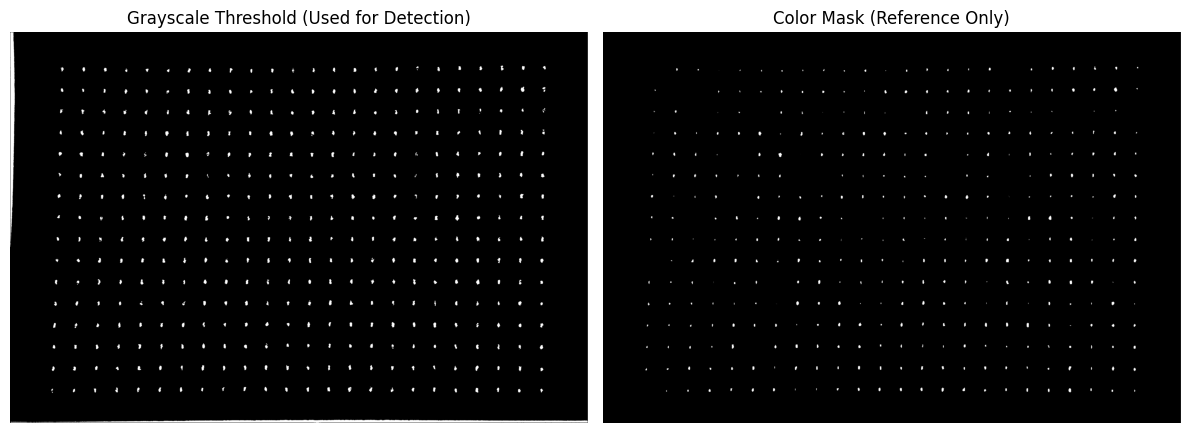


Detected 384 drops

Drop Analysis Results:


,Drop ID,X (px),Y (px),Area (px²),Perimeter (px),Circularity,Diameter (px),Score
0,A1,634.5,451.5,1016.0,186.5,0.367,36.0,-3.1
1,A2,898.0,456.3,1207.5,153.4,0.645,39.2,22.5
2,A3,1155.2,458.5,1131.5,143.2,0.694,38.0,25.5
3,A4,1416.0,470.0,610.0,101.1,0.750,27.9,68.3
4,A5,1668.1,462.6,856.0,130.2,0.634,33.0,24.2
...,...,...,...,...,...,...,...,...
379,P20,5418.3,4359.0,1028.0,137.7,0.681,36.2,44.3
380,P21,5678.5,4355.0,1523.0,171.4,0.651,44.0,43.3
381,P22,5936.0,4352.5,1049.0,148.4,0.599,36.5,19.3
382,P23,6190.1,4362.1,997.5,132.3,0.716,35.6,27.4



SUMMARY STATISTICS
Average Area: 1075.7 ± 249.4 px²
Average Circularity: 0.581 ± 0.111
Average Diameter: 36.7 ± 4.5 px
Average Score: 29.1 ± 15.4

STAGE 1 COMPLETE
Successfully detected and labeled: 384 drops
Grid range: A1 to P24
Results saved to: drop_detection_results_20250822_051305.pkl


In [33]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import pandas as pd
import string
from IPython.display import display, HTML
import io
import base64
import pickle
import json
from datetime import datetime

print("STAGE 1: Drop Detection & Labeling")
print("="*50)

# Upload image
print("Upload your drop image:")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print(f"Processing: {image_path}")

# Read image
image = cv2.imread(image_path)
original_image = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
height, width = gray.shape

print(f"Image dimensions: {width} x {height}")

# Color-based drop detection
def create_color_mask(hsv_image):
    """Create a mask for drop-colored objects"""

    # Define color ranges for drops (adjust these based on your drop color)
    # These are broad ranges to catch reddish/brownish drops
    lower_red1 = np.array([0, 30, 30])      # Lower red range
    upper_red1 = np.array([10, 255, 255])

    lower_red2 = np.array([160, 30, 30])    # Upper red range
    upper_red2 = np.array([180, 255, 255])

    lower_brown = np.array([10, 50, 20])    # Brown range
    upper_brown = np.array([25, 255, 200])

    lower_dark = np.array([0, 0, 0])        # Very dark objects
    upper_dark = np.array([180, 255, 80])

    # Create masks for each color range
    mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    mask_brown = cv2.inRange(hsv_image, lower_brown, upper_brown)
    mask_dark = cv2.inRange(hsv_image, lower_dark, upper_dark)

    # Combine all masks
    color_mask = cv2.bitwise_or(mask_red1, mask_red2)
    color_mask = cv2.bitwise_or(color_mask, mask_brown)
    color_mask = cv2.bitwise_or(color_mask, mask_dark)

    return color_mask

# Create color mask
color_mask = create_color_mask(hsv)

# Also create traditional grayscale mask
blur = cv2.GaussianBlur(gray, (5, 5), 0)
_, gray_thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours using ONLY the grayscale threshold (detects all drops)
contours, _ = cv2.findContours(gray_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Total contours detected using grayscale threshold: {len(contours)}")

# Score each contour with detailed tracking
scored_contours = []
filter_stats = {
    'total_contours': len(contours),
    'too_small': 0,
    'no_perimeter': 0,
    'edge_filtered': 0,
    'passed_initial': 0
}

for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)
    if area < 3:  # Very minimal filtering
        filter_stats['too_small'] += 1
        continue

    perimeter = cv2.arcLength(cnt, True)
    if perimeter == 0:
        filter_stats['no_perimeter'] += 1
        continue

    (x, y), radius = cv2.minEnclosingCircle(cnt)

    # Skip objects at image edges
    margin = 40  # Increased from 5 to 40 pixels
    if x < margin or y < margin or x > width - margin or y > height - margin:
        filter_stats['edge_filtered'] += 1
        continue

    filter_stats['passed_initial'] += 1

    # Basic shape measurements
    circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0

    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0

    rect = cv2.minAreaRect(cnt)
    w, h = rect[1]
    aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else float('inf')

    x_rect, y_rect, w_rect, h_rect = cv2.boundingRect(cnt)
    extent = area / (w_rect * h_rect) if (w_rect * h_rect) > 0 else 0

    # Color analysis - check the color consistency within the contour
    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [cnt], -1, 255, -1)

    # Get average color in the contour region
    mean_color = cv2.mean(hsv, mask=mask)
    hue, sat, val = mean_color[0], mean_color[1], mean_color[2]

    # Calculate comprehensive score
    score = 0

    # Size score (prefer medium sizes)
    if 8 < area < 500:
        score += 30
    elif 4 < area < 800:
        score += 20
    elif area >= 3:
        score += 10

    # Shape scores
    if circularity > 0.3:
        score += circularity * 25

    if solidity > 0.7:
        score += solidity * 20

    if aspect_ratio < 3.0:
        score += max(0, (3.0 - aspect_ratio) / 3.0) * 15

    if extent > 0.5:
        score += extent * 10

    # Color scores (boost for drop-like colors)
    # Dark objects (low value)
    if val < 100:
        score += 25

    # Reddish/brownish objects
    if (0 <= hue <= 25) or (160 <= hue <= 180):
        if sat > 30:
            score += 20

    # Medium saturation (not too gray, not too vivid)
    if 20 < sat < 200:
        score += 15

    # Penalize very bright objects (likely glare)
    if val > 200:
        score -= 20

    # Penalize very large objects (likely artifacts)
    if area > 800:
        score -= 30

    scored_contours.append({
        'contour': cnt,
        'score': score,
        'area': area,
        'perimeter': perimeter,
        'circularity': circularity,
        'solidity': solidity,
        'aspect_ratio': aspect_ratio,
        'extent': extent,
        'x': x,
        'y': y,
        'radius': radius,
        'hue': hue,
        'saturation': sat,
        'value': val
    })

print("FILTERING STATISTICS:")
print(f"Total contours found: {filter_stats['total_contours']}")
print(f"Filtered out - too small (area < 3): {filter_stats['too_small']}")
print(f"Filtered out - no perimeter: {filter_stats['no_perimeter']}")
print(f"Filtered out - too close to edges: {filter_stats['edge_filtered']}")
print(f"Passed initial filters: {filter_stats['passed_initial']}")
print(f"After scoring: {len(scored_contours)} candidates")

# STEP-BY-STEP RANKING ALGORITHM
print("\n" + "="*50)
print("Implementing step-by-step ranking algorithm...")
print("="*50)

# Step 1: Edge filter (remove drops too close to edges) - ALREADY DONE ABOVE
print("Step 1: Edge filtering - already applied during initial scoring")
edge_filtered_contours = scored_contours  # Already edge filtered

# Step 2: Proximity filter (remove duplicates based on centerpoint distance)
print("Step 2: Proximity filtering...")
def proximity_filter_step(candidates, min_distance=20):
    """Remove candidates that are too close based on centerpoint distance"""
    print(f"PROXIMITY FILTERING ALGORITHM:")
    print(f"Input: {len(candidates)} candidates")
    print(f"Minimum centerpoint distance: {min_distance} pixels")
    print(f"Algorithm:")
    print(f"1. Sort candidates by score (highest first)")
    print(f"2. For each candidate:")
    print(f"   - Check distance to all already-accepted drops")
    print(f"   - If distance < {min_distance} pixels to ANY accepted drop: REJECT")
    print(f"   - Else: ACCEPT and add to final list")
    print(f"3. This keeps highest-scoring drop when multiple drops are close")

    # Sort by score (highest first) to keep best drops when removing duplicates
    candidates_sorted = sorted(candidates, key=lambda x: x['score'], reverse=True)

    filtered = []
    rejected_count = 0

    for i, candidate in enumerate(candidates_sorted):
        too_close = False
        closest_distance = float('inf')
        closest_existing = None

        # Check centerpoint distance against all already accepted drops
        for existing in filtered:
            # Calculate Euclidean distance between centerpoints
            dist = np.sqrt((candidate['x'] - existing['x'])**2 + (candidate['y'] - existing['y'])**2)
            if dist < closest_distance:
                closest_distance = dist
                closest_existing = existing

            if dist < min_distance:
                too_close = True
                break

        if not too_close:
            filtered.append(candidate)
        else:
            rejected_count += 1
            # Show ALL rejections for debugging
            if rejected_count <= 10:
                print(f"   Rejected #{rejected_count}: drop at ({candidate['x']:.1f},{candidate['y']:.1f}) score={candidate['score']:.1f}")
                print(f"             too close ({closest_distance:.1f}px) to drop at ({closest_existing['x']:.1f},{closest_existing['y']:.1f})")

    print(f"Results: Kept {len(filtered)}, rejected {rejected_count} duplicates")

    # VERIFICATION: Check if any accepted drops are too close to each other
    print(f"VERIFICATION - Checking for remaining close drops:")
    close_pairs = 0
    for i, drop1 in enumerate(filtered):
        for j, drop2 in enumerate(filtered[i+1:], i+1):
            dist = np.sqrt((drop1['x'] - drop2['x'])**2 + (drop1['y'] - drop2['y'])**2)
            if dist < min_distance:
                close_pairs += 1
                if close_pairs <= 5:  # Show first 5 violations
                    print(f"   ERROR: Drops still too close! Distance={dist:.1f}px")
                    print(f"          Drop 1: ({drop1['x']:.1f},{drop1['y']:.1f}) score={drop1['score']:.1f}")
                    print(f"          Drop 2: ({drop2['x']:.1f},{drop2['y']:.1f}) score={drop2['score']:.1f}")

    if close_pairs == 0:
        print(f"   GOOD: No drops closer than {min_distance}px found")
    else:
        print(f"   PROBLEM: Found {close_pairs} pairs of drops still too close!")

    return filtered

proximity_filtered = proximity_filter_step(edge_filtered_contours, min_distance=20)

# Step 3: Rank by circularity (highest circularity first)
print("Step 3: Ranking by circularity...")
proximity_filtered.sort(key=lambda x: x['circularity'], reverse=True)
print(f"Ranked {len(proximity_filtered)} drops by circularity (highest first)")

# Step 4: Final ranking by area (highest area first)
print("Step 4: Final ranking by area...")
proximity_filtered.sort(key=lambda x: x['area'], reverse=True)
print(f"Final ranking by area (highest first)")

# Select exactly 384 drops (or all available if fewer)
final_drop_count = min(384, len(proximity_filtered))
selected_384_drops = proximity_filtered[:final_drop_count]

print(f"\nFINAL RESULT: Selected {len(selected_384_drops)} drops for grid assignment")
if len(selected_384_drops) < 384:
    print(f"WARNING: Could only find {len(selected_384_drops)} drops total (target: 384)")
else:
    print(f"SUCCESS: Found required 384 drops")

print(f"\nSTEP-BY-STEP SUMMARY:")
print(f"  Initial contours: {len(scored_contours)}")
print(f"  After edge filter: {len(edge_filtered_contours)}")
print(f"  After proximity filter: {len(proximity_filtered)}")
print(f"  Final selection: {len(selected_384_drops)} drops")

# YOUR EXACT GRID ASSIGNMENT LOGIC
print("\n" + "="*50)
print("Implementing your exact grid assignment algorithm...")
print("="*50)

# Step 1: Get x,y coordinates of each drop's center point
print("Step 1: Getting center coordinates...")
drop_centers = []
for drop in selected_384_drops:
    drop_centers.append({
        'x': drop['x'],
        'y': drop['y'],
        'drop_data': drop  # Keep reference to original drop
    })

# Step 2: Sort by Y coordinate (lowest Y = Row A)
print("Step 2: Sorting by Y coordinate (lowest Y = Row A)...")
drop_centers.sort(key=lambda d: d['y'])  # Lowest Y first

# Step 3: Group into exactly 16 rows of 24 drops each
print("Step 3: Grouping into 16 rows of 24 drops each...")
labeled_drops = []

for row_idx in range(16):
    # Get 24 drops for this row (or remaining drops)
    start_idx = row_idx * 24
    end_idx = min(start_idx + 24, len(drop_centers))

    if start_idx >= len(drop_centers):
        break

    row_drops = drop_centers[start_idx:end_idx]

    # Step 4: Sort this row by X coordinate (highest X = last column)
    row_drops.sort(key=lambda d: d['x'])  # Lowest X first, highest X last

    # Step 5: Assign labels A1, A2, ..., A24
    row_letter = chr(ord('A') + row_idx)  # A, B, C, ..., P

    print(f"Row {row_letter}: {len(row_drops)} drops")

    for col_idx, drop_center in enumerate(row_drops):
        # The drop with highest X in this row gets the highest column number
        drop_center['drop_data']['label'] = f"{row_letter}{col_idx + 1}"
        labeled_drops.append(drop_center['drop_data'])

print(f"Successfully labeled {len(labeled_drops)} drops using your exact algorithm")
if labeled_drops:
    print(f"Grid range: {labeled_drops[0]['label']} to {labeled_drops[-1]['label']}")

    # Verify the algorithm worked correctly
    print("Verification:")
    print(f"- Lowest Y drop should be in Row A: {min(labeled_drops, key=lambda d: d['y'])['label']}")
    print(f"- Highest Y drop should be in Row P: {max(labeled_drops, key=lambda d: d['y'])['label']}")

    # Find drops in row A and check X coordinates
    row_a_drops = [d for d in labeled_drops if d['label'].startswith('A')]
    if row_a_drops:
        highest_x_in_row_a = max(row_a_drops, key=lambda d: d['x'])
        print(f"- Highest X in Row A should be A24: {highest_x_in_row_a['label']} (X={highest_x_in_row_a['x']:.1f})")

# Create visualization with green circles and labels
print("Creating visualization with green circles and labels...")
result_image = original_image.copy()

for drop in labeled_drops:
    # Get contour and center
    contour = drop['contour']
    center_x, center_y = int(drop['x']), int(drop['y'])

    # Calculate minimum radius to contain all contour pixels
    max_distance = 0
    for point in contour:
        px, py = point[0]
        distance = np.sqrt((px - center_x)**2 + (py - center_y)**2)
        max_distance = max(max_distance, distance)

    # Circle radius: minimum needed to contain all pixels + small buffer
    circle_radius = int(max_distance) + 2
    circle_radius = max(circle_radius, 5)  # Minimum 5 pixels for visibility

    # Draw green circle around drop
    cv2.circle(result_image, (center_x, center_y), circle_radius, (0, 255, 0), 2)

    # Add label above the circle
    label_text = drop['label']

    # Calculate text position (centered above circle)
    text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
    label_x = center_x - text_size[0] // 2
    label_y = center_y - circle_radius - 5

    # Draw label text
    cv2.putText(result_image, label_text,
                (label_x, label_y),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,           # Font size
                (0, 255, 0),   # Green color
                1,             # Thickness
                cv2.LINE_AA)   # Anti-aliased

# Process data for output
drop_data = []
for drop in labeled_drops:
    diameter = 2 * np.sqrt(drop['area'] / np.pi)
    drop_data.append({
        'label': drop['label'],
        'x': drop['x'],
        'y': drop['y'],
        'area': drop['area'],
        'perimeter': drop['perimeter'],
        'circularity': drop['circularity'],
        'diameter': diameter,
        'score': drop['score']
    })

# Create DataFrame
df = pd.DataFrame(drop_data)
if not df.empty:
    df.columns = ['Drop ID', 'X (px)', 'Y (px)', 'Area (px²)', 'Perimeter (px)', 'Circularity', 'Diameter (px)', 'Score']

    # Round numerical values
    df['Area (px²)'] = df['Area (px²)'].round(1)
    df['Perimeter (px)'] = df['Perimeter (px)'].round(1)
    df['Circularity'] = df['Circularity'].round(3)
    df['Diameter (px)'] = df['Diameter (px)'].round(1)
    df['Score'] = df['Score'].round(1)
    df['X (px)'] = df['X (px)'].round(1)
    df['Y (px)'] = df['Y (px)'].round(1)

# Save detection results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_filename = f"drop_detection_results_{timestamp}.pkl"

detection_results = {
    'labeled_drops': labeled_drops,
    'image_path': image_path,
    'image_dimensions': (width, height),
    'detection_summary': {
        'total_detected': len(labeled_drops),
        'detection_timestamp': timestamp,
        'algorithm_version': 'step_by_step_v1',
        'max_drops_targeted': 384
    }
}

with open(results_filename, 'wb') as f:
    pickle.dump(detection_results, f)

# Display results with labels
print("Displaying results...")
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title(f'Drop Detection Results - {len(labeled_drops)} drops detected and labeled')

# Add labels to each drop on the plot
for drop in labeled_drops:
    plt.text(drop['x'], drop['y']-10, drop['label'],
             color='red', fontsize=8, fontweight='bold',
             ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

plt.axis("off")
plt.tight_layout()
plt.show()

# Show the masks for debugging
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(gray_thresh, cmap='gray')
axes[0].set_title('Grayscale Threshold (Used for Detection)')
axes[0].axis('off')

axes[1].imshow(color_mask, cmap='gray')
axes[1].set_title('Color Mask (Reference Only)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Display data table
if not df.empty:
    print(f"\nDetected {len(labeled_drops)} drops")
    print("\nDrop Analysis Results:")
    display(df)

    # Summary statistics
    print(f"\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    print(f"Average Area: {df['Area (px²)'].mean():.1f} ± {df['Area (px²)'].std():.1f} px²")
    print(f"Average Circularity: {df['Circularity'].mean():.3f} ± {df['Circularity'].std():.3f}")
    print(f"Average Diameter: {df['Diameter (px)'].mean():.1f} ± {df['Diameter (px)'].std():.1f} px")
    print(f"Average Score: {df['Score'].mean():.1f} ± {df['Score'].std():.1f}")

print(f"\nSTAGE 1 COMPLETE")
print(f"Successfully detected and labeled: {len(labeled_drops)} drops")
if labeled_drops:
    print(f"Grid range: {labeled_drops[0]['label']} to {labeled_drops[-1]['label']}")
print(f"Results saved to: {results_filename}")